# Load the Segmented Data

In [2]:
import pandas as pd
import numpy as np
import sys
import os
from sklearn.model_selection import train_test_split

# Add the project root to the Python path to allow importing from 'src'
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

try:
    from src.data_utils import load_and_label_data, segment_signals
except ImportError as e:
    print(f"Error importing from src.data_utils: {e}")
    # Handle error or guide user
    raise

# 1. Load the raw data
print("Loading raw data...")
raw_data_list = load_and_label_data() # This calls functions from your data_utils
if not raw_data_list:
    raise ValueError("Failed to load raw data. Check src/data_utils.py and data paths.")
loaded_df = pd.DataFrame(raw_data_list)
print(f"Loaded {len(loaded_df)} raw signals.")

# 2. Segment the loaded signals
WINDOW_SIZE = 2048
OVERLAP_RATIO = 0.5
print(f"Segmenting signals (Window: {WINDOW_SIZE}, Overlap: {OVERLAP_RATIO*100}%)...")
segmented_df = segment_signals(loaded_df, window_size=WINDOW_SIZE, overlap_ratio=OVERLAP_RATIO)
if segmented_df.empty:
    raise ValueError("Segmentation resulted in an empty DataFrame. Check parameters.")
print(f"Generated {len(segmented_df)} segments.")
print("Segmented DataFrame head:\n", segmented_df.head())

Loading raw data...
Successfully loaded and processed: Normal_0.mat
Successfully loaded and processed: IR007_0.mat
Successfully loaded and processed: B007_0.mat
Successfully loaded and processed: OR007@6_0.mat
Info: Using expected_rpm (1772) for Normal_1.mat.
Successfully loaded and processed: Normal_1.mat
Successfully loaded and processed: IR007_1.mat
Successfully loaded and processed: B007_1.mat
Successfully loaded and processed: OR007@6_1.mat
Info: Using expected_rpm (1750) for Normal_2.mat.
Successfully loaded and processed: Normal_2.mat
Successfully loaded and processed: IR007_2.mat
Successfully loaded and processed: B007_2.mat
Successfully loaded and processed: OR007@6_2.mat
Loaded 12 raw signals.
Segmenting signals (Window: 2048, Overlap: 50.0%)...
Generated 2238 segments.
Segmented DataFrame head:
   config_name original_filename fault_type  motor_load_hp     rpm  \
0  Normal_0HP      Normal_0.mat     Normal              0  1796.0   
1  Normal_0HP      Normal_0.mat     Normal  

# Split Data into Training/Validation and Test Sets

In [3]:
# Separate the test set (2 HP load conditions)
test_df = segmented_df[segmented_df['motor_load_hp'] == 2].copy()
print(f"Test set size (2 HP data): {len(test_df)} segments")

# Pool for training and validation (0 HP and 1 HP load conditions)
train_val_pool_df = segmented_df[segmented_df['motor_load_hp'].isin([0, 1])].copy()
print(f"Training+Validation pool size (0 HP + 1 HP data): {len(train_val_pool_df)} segments")

# Check if any data was lost
if len(test_df) + len(train_val_pool_df) != len(segmented_df):
    print("Warning: Mismatch in segment counts during train/test split!")

# At this point, 'test_df' is your test set.
# 'train_val_pool_df' needs to be split into training and validation sets.

Test set size (2 HP data): 824 segments
Training+Validation pool size (0 HP + 1 HP data): 1414 segments


# Split Training+Validation Pool into Training and Validation Sets

In [4]:
# Define features (X) and target (y) for the train_val_pool
# The 'signal_segment' is our feature, and 'fault_type' is our primary target.
X_train_val = np.stack(train_val_pool_df['signal_segment'].values) # Stack segments into a NumPy array
y_train_val = train_val_pool_df['fault_type'].values

# Perform the split (e.g., 80% train, 20% validation)
# random_state ensures reproducibility
# stratify by y_train_val to maintain class proportions
TRAIN_SPLIT_RATIO = 0.8 # 80% for training
VAL_SPLIT_RATIO = 1 - TRAIN_SPLIT_RATIO # 20% for validation

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, 
    y_train_val, 
    test_size=VAL_SPLIT_RATIO, 
    random_state=42, # For reproducibility
    stratify=y_train_val 
)

print(f"Training set shape: X_train = {X_train.shape}, y_train = {y_train.shape}")
print(f"Validation set shape: X_val = {X_val.shape}, y_val = {y_val.shape}")

# Prepare the test set features and labels
X_test = np.stack(test_df['signal_segment'].values)
y_test = test_df['fault_type'].values
print(f"Test set shape: X_test = {X_test.shape}, y_test = {y_test.shape}")

print("\nDistribution of fault types in training set:")
print(pd.Series(y_train).value_counts(normalize=True).sort_index())
print("\nDistribution of fault types in validation set:")
print(pd.Series(y_val).value_counts(normalize=True).sort_index())
print("\nDistribution of fault types in test set:")
print(pd.Series(y_test).value_counts(normalize=True).sort_index())

Training set shape: X_train = (1131, 2048), y_train = (1131,)
Validation set shape: X_val = (283, 2048), y_val = (283,)
Test set shape: X_test = (824, 2048), y_test = (824,)

Distribution of fault types in training set:
BF        0.166225
IRF       0.166225
Normal    0.500442
ORF       0.167109
Name: proportion, dtype: float64

Distribution of fault types in validation set:
BF        0.166078
IRF       0.166078
Normal    0.501767
ORF       0.166078
Name: proportion, dtype: float64

Distribution of fault types in test set:
BF        0.141990
IRF       0.143204
Normal    0.572816
ORF       0.141990
Name: proportion, dtype: float64


# Creating Balanced Version of Training Set

In [5]:
# pip install imbalanced-learn

In [6]:
# Import SMOTE
try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    print("imblearn library not found. Please install it: pip install imbalanced-learn")
    # You might want to raise an error or stop execution if not found
    raise

print("Original training set class distribution:")
print(pd.Series(y_train).value_counts(normalize=True).sort_index().to_string())
print(f"Original training set shape: X_train = {X_train.shape}, y_train = {y_train.shape}\n")

# Initialize SMOTE
# random_state for reproducibility
# k_neighbors is a parameter for SMOTE; default is 5. Adjust if needed, but default is usually fine to start.
smote = SMOTE(random_state=42)

print("Applying SMOTE to the training data to create a balanced training set...")
# Fit SMOTE and resample the training data ONLY
# X_train should be 2D (num_samples, num_features) which it is (e.g., (1131, 2048))
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("\n--- Balanced Training Set Statistics ---")
print("Balanced training set class distribution (after SMOTE):")
print(pd.Series(y_train_balanced).value_counts(normalize=True).sort_index().to_string())
print(f"Balanced training set shape: X_train_balanced = {X_train_balanced.shape}, y_train_balanced = {y_train_balanced.shape}")

# Verify the counts for each class in the balanced set
print("\nCounts for each class in the balanced training set:")
print(pd.Series(y_train_balanced).value_counts().sort_index().to_string())

# IMPORTANT: The validation and test sets remain unchanged (imbalanced)
print("\nReminder: Validation and Test sets remain in their original imbalanced distribution.")
print(f"Validation set shape: X_val = {X_val.shape}, y_val = {y_val.shape}")
print(f"Test set shape: X_test = {X_test.shape}, y_test = {y_test.shape}")

Original training set class distribution:
BF        0.166225
IRF       0.166225
Normal    0.500442
ORF       0.167109
Original training set shape: X_train = (1131, 2048), y_train = (1131,)

Applying SMOTE to the training data to create a balanced training set...

--- Balanced Training Set Statistics ---
Balanced training set class distribution (after SMOTE):
BF        0.25
IRF       0.25
Normal    0.25
ORF       0.25
Balanced training set shape: X_train_balanced = (2264, 2048), y_train_balanced = (2264,)

Counts for each class in the balanced training set:
BF        566
IRF       566
Normal    566
ORF       566

Reminder: Validation and Test sets remain in their original imbalanced distribution.
Validation set shape: X_val = (283, 2048), y_val = (283,)
Test set shape: X_test = (824, 2048), y_test = (824,)


# Visualizing Statistics of Dataset Split & Balance

--- Generating Plots for Dataset Split and Balancing Statistics ---


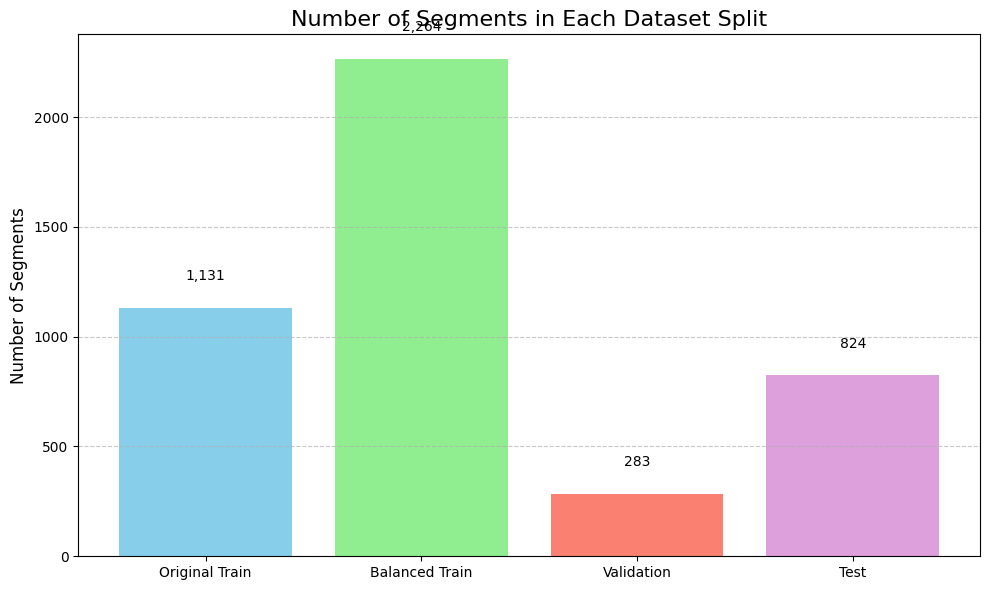

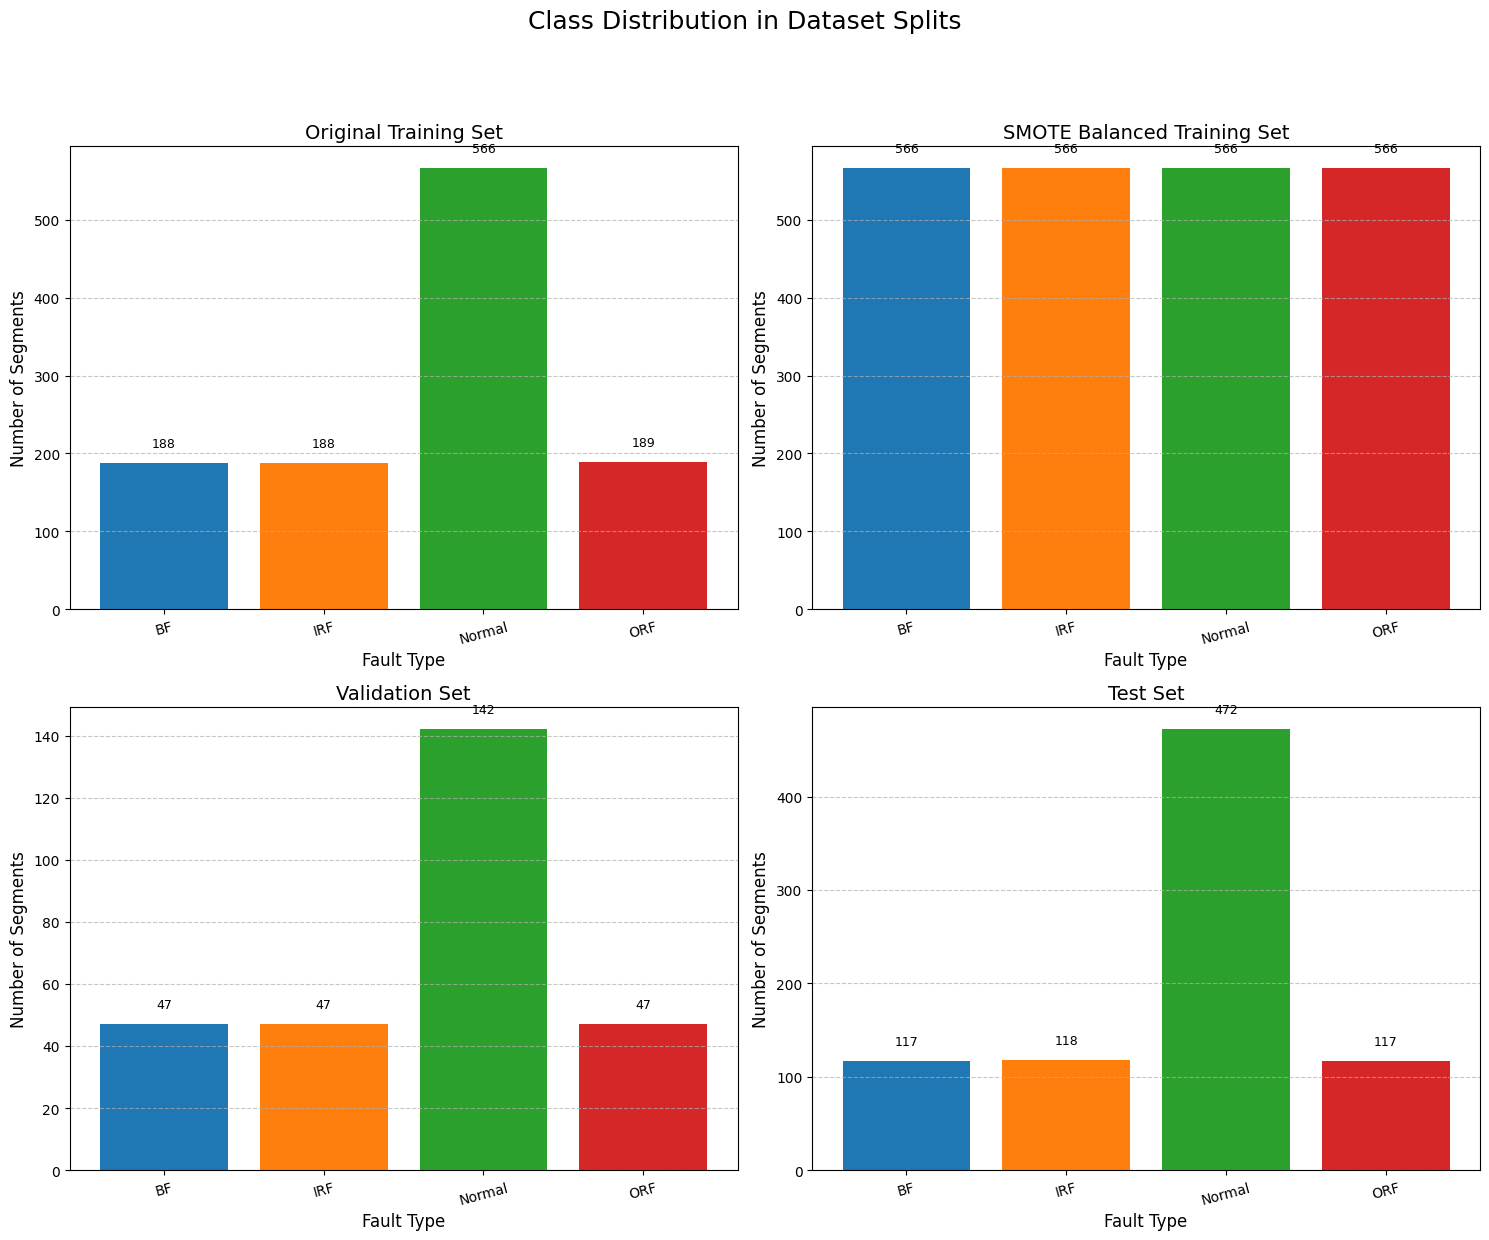


--- Plot generation complete ---


In [7]:
import matplotlib.pyplot as plt
import pandas as pd # Should already be imported, but good practice

# Ensure all necessary variables (y_train, y_train_balanced, y_val, y_test) are available
# from previous cells.

print("--- Generating Plots for Dataset Split and Balancing Statistics ---")

# Data for Plot 1: Dataset Split Sizes
split_names = ['Original Train', 'Balanced Train', 'Validation', 'Test']
split_counts = [len(y_train), len(y_train_balanced), len(y_val), len(y_test)]

# Plot 1: Bar chart for Dataset Split Sizes
plt.figure(figsize=(10, 6))
bars = plt.bar(split_names, split_counts, color=['skyblue', 'lightgreen', 'salmon', 'plum'])
plt.title('Number of Segments in Each Dataset Split', fontsize=16)
plt.ylabel('Number of Segments', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# Add counts on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.05 * max(split_counts) , f'{yval:,}', ha='center', va='bottom', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Data for Plot 2: Class Distributions
datasets_for_plot = {
    'Original Training Set': y_train,
    'SMOTE Balanced Training Set': y_train_balanced,
    'Validation Set': y_val,
    'Test Set': y_test
}

# Determine the order of fault types for consistent plotting
# (assuming all fault types are present in y_train at least)
fault_type_order = sorted(pd.Series(y_train).unique()) 

# Plot 2: Bar charts for Class Distributions in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Class Distribution in Dataset Splits', fontsize=18, y=1.03)
axes = axes.flatten() # Flatten the 2x2 array for easy iteration

for i, (title, data) in enumerate(datasets_for_plot.items()):
    ax = axes[i]
    class_counts = pd.Series(data).value_counts().reindex(fault_type_order, fill_value=0) # Ensure consistent order and include all classes
    
    bars = ax.bar(class_counts.index, class_counts.values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']) # Default matplotlib colors
    ax.set_title(title, fontsize=14)
    ax.set_ylabel('Number of Segments', fontsize=12)
    ax.set_xlabel('Fault Type', fontsize=12)
    ax.tick_params(axis='x', rotation=15, labelsize=10) # Rotate x-labels slightly if needed
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add counts on top of bars
    for bar in bars:
        yval = bar.get_height()
        if yval > 0: # Only add text if bar height is > 0
            ax.text(bar.get_x() + bar.get_width()/2.0, yval + 0.03 * class_counts.max(), f'{int(yval):,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to make space for suptitle
plt.show()

print("\n--- Plot generation complete ---")

# Data Normalization

In [8]:
from sklearn.preprocessing import StandardScaler
import numpy as np # Should already be imported

# Ensure X_train, X_train_balanced, X_val, X_test are available from previous cells.
# These are NumPy arrays where each row is a signal segment.

print("--- Starting Data Normalization (StandardScaler) ---")

# 1. Initialize the StandardScaler
scaler = StandardScaler()

# 2. Fit the scaler ONLY on the original (imbalanced) training data (X_train)
print("Fitting StandardScaler on the original training data (X_train)...")
# X_train is (n_samples, n_features), where n_features is your window_size (2048)
scaler.fit(X_train) 

# 3. Transform all datasets using the FITTED scaler
print("Transforming datasets...")
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Also transform the SMOTE-balanced training data using the same scaler
X_train_balanced_scaled = scaler.transform(X_train_balanced)

print("\n--- Normalization Complete ---")
print(f"Shape of X_train_scaled: {X_train_scaled.shape}")
print(f"Shape of X_train_balanced_scaled: {X_train_balanced_scaled.shape}")
print(f"Shape of X_val_scaled: {X_val_scaled.shape}")
print(f"Shape of X_test_scaled: {X_test_scaled.shape}")

# 4. Verification (Optional but good practice)
# Check the mean and standard deviation of the scaled training data.
# They should be close to 0 and 1, respectively, for each feature (time point).
print("\nVerification of scaling on X_train_scaled (sample of features):")
print(f"  Mean of first 5 features (time points) in X_train_scaled: {np.mean(X_train_scaled[:, :5], axis=0)}")
print(f"  Std Dev of first 5 features (time points) in X_train_scaled: {np.std(X_train_scaled[:, :5], axis=0)}")

# Check one sample from original and scaled training data
print("\nExample of one original segment from X_train (first 10 values):")
print(X_train[0, :10])
print("Example of that same segment scaled (X_train_scaled, first 10 values):")
print(X_train_scaled[0, :10])

--- Starting Data Normalization (StandardScaler) ---
Fitting StandardScaler on the original training data (X_train)...
Transforming datasets...

--- Normalization Complete ---
Shape of X_train_scaled: (1131, 2048)
Shape of X_train_balanced_scaled: (2264, 2048)
Shape of X_val_scaled: (283, 2048)
Shape of X_test_scaled: (824, 2048)

Verification of scaling on X_train_scaled (sample of features):
  Mean of first 5 features (time points) in X_train_scaled: [-5.46767661e-17 -2.91543977e-17 -1.02089474e-17  1.21574820e-16
 -5.56706660e-17]
  Std Dev of first 5 features (time points) in X_train_scaled: [1. 1. 1. 1. 1.]

Example of one original segment from X_train (first 10 values):
[-0.02858031 -0.06091569 -0.06279323 -0.04631262 -0.03504738 -0.05882954
 -0.08866154 -0.06863446 -0.02336492  0.01940123]
Example of that same segment scaled (X_train_scaled, first 10 values):
[-0.12667204 -0.240348   -0.24602302 -0.20999358 -0.14135865 -0.22451124
 -0.33631953 -0.26211035 -0.11373473  0.04170817

--- Generating Plot: Distribution of a Single Selected Feature Before & After Normalization ---


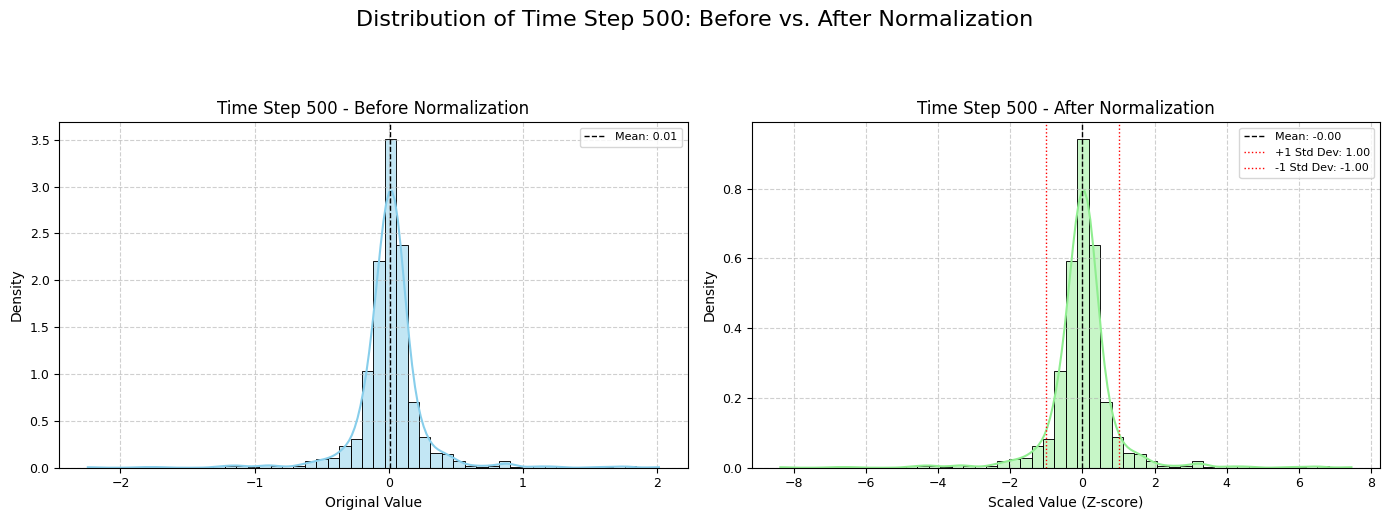

In [9]:
# In a new cell in 02_preprocessing_feature_engineering_and_augmentation.ipynb
import matplotlib.pyplot as plt
import numpy as np # Should already be imported
import pandas as pd # Should already be imported
import seaborn as sns # For potentially nicer KDE plots

# Ensure X_train and X_train_scaled are available

print("--- Generating Plot: Distribution of a Single Selected Feature Before & After Normalization ---")

# Select ONE feature index (time step) to visualize
# For example, the 500th time step in your 2048-sample window. Choose one that you think is representative.
# You can experiment with different indices.
feature_index_to_plot = 500 # <<<< YOU CAN CHANGE THIS INDEX

if feature_index_to_plot >= X_train.shape[1]:
    print(f"Error: feature_index_to_plot ({feature_index_to_plot}) is out of bounds for data with {X_train.shape[1]} features.")
else:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5)) # 1 row, 2 columns
    fig.suptitle(f'Distribution of Time Step {feature_index_to_plot}: Before vs. After Normalization', fontsize=16, y=1.03)

    # Data for the current feature
    data_before = X_train[:, feature_index_to_plot]
    data_after = X_train_scaled[:, feature_index_to_plot]
    
    # Plot: Before Normalization (Column 1) - Using Seaborn Histplot with KDE
    ax_before = axes[0]
    sns.histplot(data_before, kde=True, ax=ax_before, color='skyblue', stat="density", bins=50)
    ax_before.set_title(f'Time Step {feature_index_to_plot} - Before Normalization', fontsize=12)
    ax_before.set_xlabel('Original Value', fontsize=10)
    ax_before.set_ylabel('Density', fontsize=10)
    ax_before.grid(True, linestyle='--', alpha=0.6)
    ax_before.tick_params(labelsize=9)
    ax_before.axvline(data_before.mean(), color='k', linestyle='dashed', linewidth=1, label=f'Mean: {data_before.mean():.2f}')
    ax_before.legend(fontsize=8)


    # Plot: After Normalization (Column 2) - Using Seaborn Histplot with KDE
    ax_after = axes[1]
    sns.histplot(data_after, kde=True, ax=ax_after, color='lightgreen', stat="density", bins=50)
    ax_after.set_title(f'Time Step {feature_index_to_plot} - After Normalization', fontsize=12)
    ax_after.set_xlabel('Scaled Value (Z-score)', fontsize=10)
    ax_after.set_ylabel('Density', fontsize=10) # Y-axis label can be same if using density
    ax_after.grid(True, linestyle='--', alpha=0.6)
    ax_after.tick_params(labelsize=9)
    # Add lines for mean (should be ~0) and +/- 1 std dev (should be ~ +/-1)
    ax_after.axvline(data_after.mean(), color='k', linestyle='dashed', linewidth=1, label=f'Mean: {data_after.mean():.2f}')
    ax_after.axvline(data_after.mean() + data_after.std(), color='r', linestyle='dotted', linewidth=1, label=f'+1 Std Dev: {(data_after.mean() + data_after.std()):.2f}')
    ax_after.axvline(data_after.mean() - data_after.std(), color='r', linestyle='dotted', linewidth=1, label=f'-1 Std Dev: {(data_after.mean() - data_after.std()):.2f}')
    ax_after.legend(fontsize=8)

    plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to make space for suptitle
    plt.show()

# Save Processed Data

In [10]:
import numpy as np # Should already be imported
import os
import joblib # For saving the scaler

# Define the directory to save processed data
# Assumes your notebook is in 'AI-Bearing-Diagnosis/notebooks/'
# and you want to save to 'AI-Bearing-Diagnosis/data/processed/'
PROCESSED_DATA_DIR = os.path.join(project_root, 'data', 'processed') # project_root defined in earlier cells

# Create the directory if it doesn't exist
if not os.path.exists(PROCESSED_DATA_DIR):
    os.makedirs(PROCESSED_DATA_DIR)
    print(f"Created directory: {PROCESSED_DATA_DIR}")
else:
    print(f"Directory already exists: {PROCESSED_DATA_DIR}")

print("\n--- Saving Processed Datasets ---")

try:
    # Save the NumPy arrays
    
    # Data from original (imbalanced) training split
    np.save(os.path.join(PROCESSED_DATA_DIR, 'X_train_scaled.npy'), X_train_scaled)
    np.save(os.path.join(PROCESSED_DATA_DIR, 'y_train.npy'), y_train)
    
    # Data from SMOTE-balanced training split
    np.save(os.path.join(PROCESSED_DATA_DIR, 'X_train_balanced_scaled.npy'), X_train_balanced_scaled)
    np.save(os.path.join(PROCESSED_DATA_DIR, 'y_train_balanced.npy'), y_train_balanced)
    
    # Validation data
    np.save(os.path.join(PROCESSED_DATA_DIR, 'X_val_scaled.npy'), X_val_scaled)
    np.save(os.path.join(PROCESSED_DATA_DIR, 'y_val.npy'), y_val)
    
    # Test data - THIS IS THE CORRECTED LINE
    np.save(os.path.join(PROCESSED_DATA_DIR, 'X_test_scaled.npy'), X_test_scaled) 
    np.save(os.path.join(PROCESSED_DATA_DIR, 'y_test.npy'), y_test)

    print("\nSuccessfully saved feature and label arrays:")
    # ... (rest of the print statements) ...

    # Save the fitted StandardScaler object
    scaler_filename = os.path.join(PROCESSED_DATA_DIR, 'standard_scaler.joblib')
    joblib.dump(scaler, scaler_filename)
    print(f"\nSuccessfully saved the fitted StandardScaler to: {scaler_filename}")

except Exception as e:
    print(f"An error occurred during saving: {e}")

print("\n--- Saving Process Complete ---")

Directory already exists: D:\Coding\GitHub\AI-Bearing-Diagnosis\data\processed

--- Saving Processed Datasets ---

Successfully saved feature and label arrays:

Successfully saved the fitted StandardScaler to: D:\Coding\GitHub\AI-Bearing-Diagnosis\data\processed\standard_scaler.joblib

--- Saving Process Complete ---


# Create Sample Signals for Testing (will be used later in the demo)

In [11]:
# (Assuming X_test and y_test are loaded from your preprocessing steps)
import numpy as np

# Find the index of the first occurrence of each class in the test set
idx_normal = np.where(y_test == 'Normal')[0][0]
idx_irf = np.where(y_test == 'IRF')[0][0]
idx_bf = np.where(y_test == 'BF')[0][0]
idx_orf = np.where(y_test == 'ORF')[0][0]

# Extract the corresponding 2048-sample signals
signal_normal = X_test[idx_normal]
signal_irf = X_test[idx_irf]
signal_bf = X_test[idx_bf]
signal_orf = X_test[idx_orf]

# Save each signal to a CSV file in your new app folder
# Make sure to adjust the path to your streamlit_app directory
APP_FOLDER_PATH = '../streamlit_app' 
np.savetxt(f"{APP_FOLDER_PATH}/test_signal_normal.csv", signal_normal, delimiter=",")
np.savetxt(f"{APP_FOLDER_PATH}/test_signal_irf.csv", signal_irf, delimiter=",")
np.savetxt(f"{APP_FOLDER_PATH}/test_signal_bf.csv", signal_bf, delimiter=",")
np.savetxt(f"{APP_FOLDER_PATH}/test_signal_orf.csv", signal_orf, delimiter=",")

print("Sample signal files saved successfully!")

Sample signal files saved successfully!


In [14]:
# --- Create Advanced Test Signals ---
import numpy as np
import pandas as pd
import os

# (Assuming X_test, y_test, and scaler are loaded from previous steps)
APP_FOLDER_PATH = '../streamlit_app' 

# 1. Create a SHORT signal by truncating a normal signal
signal_normal = X_test[np.where(y_test == 'Normal')[0][0]]
short_signal = signal_normal[:1500]
np.savetxt(f"{APP_FOLDER_PATH}/test_signal_normal_short.csv", short_signal, delimiter=",")
print(f"Saved normal short signal with length: {len(short_signal)}")

# 2. Create a NOISY signal with 60% noise
signal_bf = X_test[np.where(y_test == 'BF')[0][0]]
noise_std = signal_bf.std() * 0.60
noise = np.random.normal(0, noise_std, signal_bf.shape)
noisy_signal_bf = signal_bf + noise
np.savetxt(f"{APP_FOLDER_PATH}/test_signal_bf_noisy_60.csv", noisy_signal_bf, delimiter=",")
print(f"Saved noisy ball fault signal with length: {len(noisy_signal_bf)}")

# 3. Create a LONG signal by concatenating three different signals
signal_irf = X_test[np.where(y_test == 'IRF')[0][0]]
long_signal = np.concatenate([signal_normal, signal_irf, signal_normal])
np.savetxt(f"{APP_FOLDER_PATH}/test_signal_long_noraml_irf_normal.csv", long_signal, delimiter=",")
print(f"Saved long mixed signal 'test_signal_long_noraml_irf_normal' with length: {len(long_signal)}")

# 4. Create another LONG signal by concatenating 5 different signals
signal_irf = X_test[np.where(y_test == 'IRF')[0][0]]
long_signal = np.concatenate([signal_normal, signal_irf, signal_normal, signal_irf, signal_irf])
np.savetxt(f"{APP_FOLDER_PATH}/test_signal_long_noraml_irf_normal_irf_irf.csv", long_signal, delimiter=",")
print(f"Saved long mixed signal 'test_signal_long_noraml_irf_normal_irf_irf' with length: {len(long_signal)}")

# 5. Create another LONG signal by concatenating 5 different signals
signal_irf = X_test[np.where(y_test == 'IRF')[0][0]]
long_signal = np.concatenate([signal_bf, signal_bf, signal_normal, signal_irf, signal_irf])
np.savetxt(f"{APP_FOLDER_PATH}/test_signal_long_bf_bf_normal_irf_irf.csv", long_signal, delimiter=",")
print(f"Saved long mixed signal 'test_signal_long_bf_bf_normal_irf_irf' with length: {len(long_signal)}")

Saved normal short signal with length: 1500
Saved noisy ball fault signal with length: 2048
Saved long mixed signal 'test_signal_long_noraml_irf_normal' with length: 6144
Saved long mixed signal 'test_signal_long_noraml_irf_normal_irf_irf' with length: 10240
Saved long mixed signal 'test_signal_long_bf_bf_normal_irf_irf' with length: 10240
